We want to resolve the following system of equations:
$$-\nabla\cdot q(u)\nabla(u) = f,$$
$$u=g\text{ on }\Gamma_D,$$
$$\nabla u\cdot n=f\text{ on }\Gamma_N.$$
where $q(u)$ is a non-linear function. The non-linearity in
the coefficients $q(u)$ makes the equation non-linear. 

The variational problem is find $u\in V$ such that

$$A(u,v) = L(v), \quad \forall v\in \hat{V},$$

where $$A(u,v) = \int_\Omega q(u)\nabla(u)\cdot\nabla(v)dx$$ and $$L(v) = \int_\Omega fvdx.$$
With  $$v\in \hat{V}=\{\    v\in H^1(\Omega): v=0\text{ on }\Gamma_D\},$$
and $$u\in V=\{\    v\in H^1(\Omega): v=g\text{ on }\Gamma_D\}.$$

Let the space $V_h$ be the finite element space of piecewise such that $V_h\subset V$, and $\{\phi_i\}_{i=1}^N$ be a basis of $V_h$. Then, the variational problem can be written as find $u_h\in V_h$ such that    
$$A(u_h,v_h) = L_h(v_h), \quad \forall v_h\in \hat{V}_h,$$
where $$A(u_h,v_h) = \sum_{j=1}^N a_{j}\langle q\Big(\sum_{j=1}^N a_{j}\phi_j\Big)\phi_j,\phi_i\rangle$$ and $$L(v_h) = \langle f,\phi_i\rangle,$$

thus, we can define the function $F$ such that

$$F(a_1,...,a_N)=A(u_h,v_h) - L_h(v_h),$$
thereby, we can solve the problem by finding the roots of $F$, and then, we can used the Newton method to find the roots of $F$. Note to use the Newton method, we need to compute the Jacobian of $F$ and following algorit:
we can definite $a^k=[a^{(k)}_1,...,a^{(k)}_N]$  
1. Choose an initial guess $a^0$.
2. Compute the Jacobian $J$ of $F$ at $a^k$.
3. Solve the linear system $J\delta a = -F(a^k)$.
4. Update $a^(k+1) = a^k + \omega \delta a$ 
5. If $||a^{k+1}-a^k||>\epsilon$ then it goes to step 2.

Thus, we can calculate the Jacobian of the function $F$,
First, we need to compute the derivative of $A(u_h,v_h)$, and then, we can compute the derivative of $L_h(v_h)$, and finally, we can compute the derivative of $F$.




$$\frac{\partial }{\partial a_j}A(u_h,v_h) = \sum_{j=1}^N\frac{\partial }{\partial a_j}\Big( a_{j}\int_{\Omega} q\Big(\sum_{j=1}^N a_{j}\phi_j\Big)\phi_j,\phi_i \, dx\Big),$$


Nonlinear Poisson equation with Dirichlet conditions in x-direction and homogeneous Neumann (symmetry) conditions in all other directions. The domain is the unit hypercube in of a given dimension.
$$-\nabla\cdot q(u)\nabla(u) = 0,$$
$$u = 0 \text{ at }x=0, u=1\text{ at } x=1, \frac{du}{dn}=0 \text{at all other boundaries}.$$
where $q(u) = (1+u)^m$

In [1]:
from dolfin import *
import numpy, sys

In [2]:
# Create mesh and define function space
mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, 'Lagrange', 1)

# Define boundary conditions for initial guess
tol = 1E-14
def left_boundary(x, on_boundary):
    return on_boundary and abs(x[0]) < tol

def right_boundary(x, on_boundary):
    return on_boundary and abs(x[0]-1) < tol

Gamma_0 = DirichletBC(V, Constant(0.0), left_boundary)
Gamma_1 = DirichletBC(V, Constant(1.0), right_boundary)
bcs = [Gamma_0, Gamma_1]

# Define variational problem for initial guess (q(u)=1, i.e., m=0)
u = TrialFunction(V)
v = TestFunction(V)
a = inner(nabla_grad(u), nabla_grad(v))*dx
f = Constant(0.0)
L = f*v*dx
u_k = Function(V)
solve(a == L, u_k, bcs)

Solving linear variational problem.


Note that $u_k$ is the solution to previous method, and it is the initial condition to Newtom method. The Dirichlet boundary condition to solved somewhat different than the condictions for $u$. The boundary condition for $u$ is $u(0)=0$ and $u(1)=0$. The boundary condition for $u_k$ is $u_k(0)=0$ and $u_k(1)=0$. The boundary condition for $u_{k+1}$. 

In [3]:

# Note that all Dirichlet conditions must be zero for
# the correction function in a Newton-type method
Gamma_0_du = DirichletBC(V, Constant(0.0), left_boundary)
Gamma_1_du = DirichletBC(V, Constant(0.0), right_boundary)
bcs_du = [Gamma_0_du, Gamma_1_du]

1 iteration
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Norm: 0.1809927186254711
2 iteration
Norm: 0.019833119264101667
3 iteration
Norm: 0.0002695503921713258
4 iteration
Norm: 4.950025988032694e-08
Object cannot be plotted directly, projecting to piecewise linears.
Max error: 0.00018534486459209631


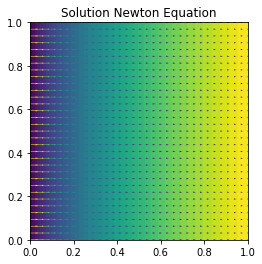

In [4]:
# Choice of nonlinear coefficient
m = 2

def q(u):
    return (1+u)**m

def Dq(u):
    return m*(1+u)**(m-1)

# Define variational problem for Newton iteration
du = TrialFunction(V)  # u = u_k + omega*du
a = inner(q(u_k)*nabla_grad(du), nabla_grad(v))*dx + \
    inner(Dq(u_k)*du*nabla_grad(u_k), nabla_grad(v))*dx
L = -inner(q(u_k)*nabla_grad(u_k), nabla_grad(v))*dx

# Newton iteration at the PDE level
du = Function(V)
u  = Function(V)  # u = u_k + omega*du
omega = 1.0       # relaxation parameter
eps = 1.0
tol = 1.0E-5
iter = 0
maxiter = 25
# u_k must have right boundary conditions here
while eps > tol and iter < maxiter:
    iter += 1
    print (iter, 'iteration')
    A, b = assemble_system(a, L, bcs_du)
    solve(A, du.vector(), b)
    diff = du.vector()
    eps = numpy.linalg.norm(diff, ord=numpy.Inf)
    print ('Norm:', eps)
    u.vector()[:] = u_k.vector() + omega*du.vector()
    u_k.assign(u)
plot(u)
plot(grad(u), title="Solution Newton Equation")
# Save solution in VTK format
file = File("newton_alg/nonlinear_poisson.pvd")
file << u


# Find max error
u_exact = Expression('pow((pow(2, m+1)-1)*x[0] + 1, 1.0/(m+1)) - 1', m=m,degree=2)
u_e = interpolate(u_exact, V)
diff = numpy.abs(u_e.vector() - u.vector()).max()
print('Max error:', diff)